In [11]:
import cv2
import numpy as np
import sys
from PIL import Image
import math
import matplotlib.pyplot as plt
sys.path.insert(0, '/Users/ebiharamari/Sources/spherical_warper_pybind/build/')
import spherical_warper

In [12]:
import sys
print(sys.version)
print(sys.executable)

3.13.0 (main, May 31 2025, 16:20:09) [Clang 17.0.0 (clang-1700.0.13.5)]
/Users/marimurotani/.pyenv/versions/3.13.0/envs/spherical-warp-env/bin/python


In [13]:
def rotation_matrix_yaw_pitch(yaw_deg, pitch_deg):
    """Yaw（水平）とPitch（垂直）から回転行列Rを生成"""
    yaw = math.radians(yaw_deg)
    pitch = math.radians(pitch_deg)

    # yaw方向のrotation行列
    Ry = np.array([
        [math.cos(yaw), 0, math.sin(yaw)],
        [0, 1, 0],
        [-math.sin(yaw), 0, math.cos(yaw)],
    ])

    # pitch方向のrotation行列
    Rx = np.array([
        [1, 0, 0],
        [0, math.cos(pitch), -math.sin(pitch)],
        [0, math.sin(pitch), math.cos(pitch)],
    ])

    # Rx @ Ry → 行列の積（回転行列の合成)
    return (Rx @ Ry).tolist()

Input image shape: (340, 508, 3)
Canvas shape: (512, 1024, 4)
Executed Image:  (443, 570, 3)


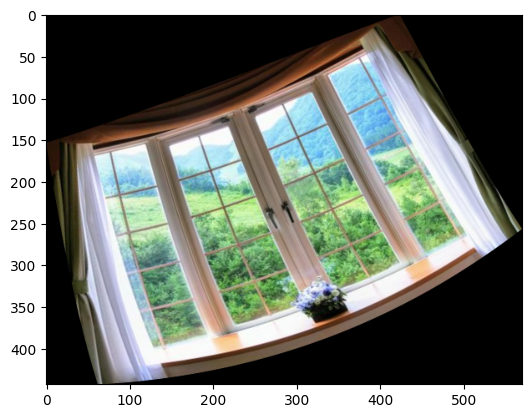

In [14]:
img = cv2.imread('window.jpeg', cv2.IMREAD_UNCHANGED)
print("Input image shape:", img.shape)

# 入力画像サイズ
H, W = img.shape[:2]

# カメラ行列 K
# 焦点距離（画素単位）
f = 500.0
# カメラ行列 K の定義
#  K = [ fx  0  cx ]
#    [ 0  fy  cy ]
#    [ 0   0   1 ]
#  fx, fy: 焦点距離（画素単位）
#  cx, cy: 画像の中心（principal point）
K = [[f, 0, W / 2],
     [0, f, H / 2],
     [0, 0, 1]]

# 出力サイズ（equirectangular 2:1）
out_w, out_h = 1024, 512
canvas = np.zeros((out_h, out_w, 4), dtype=np.uint8)
print("Canvas shape:", canvas.shape)

# yaw/pitch を指定して、視野方向の patch を得る
yaw_deg = 45
pitch_deg = -30
R = rotation_matrix_yaw_pitch(yaw_deg, pitch_deg)

warped_patch = spherical_warper.warp_spherical(img, f, K, R)
print("Executed Image: ", warped_patch.shape)
warped_patch = cv2.cvtColor(warped_patch, cv2.COLOR_BGR2RGBA)
plt.imshow(warped_patch)